In [2]:
import pandas as pd
import numpy as np
import os # To set our working folder
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
import statsmodels.api as sm
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

if os.name=='nt':
    #import eikon as ek
    import xlwings as xw


def to_event_date(df, evdate):
    if isinstance(evdate, str):
        evdate = datetime.strptime(evdate, "%Y-%m-%d")
    elif not isinstance(evdate, datetime):
        print('check date format')
        return None
    df = df.copy()
    df.reset_index(inplace=True)
    df['drift'] = (df['Date'] - evdate).apply(lambda x: x.days)
    df['drift'] = df['drift'].where(df['drift']>=0)
    event_date = df.loc[df['drift'].argmin()]['Date']
    return event_date


def find_earliest_busines_date(date, estwindow, retwindow):  # https://stackoverflow.com/questions/39067626/determine-if-a-day-is-a-business-day-in-python-pandas
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    elif not isinstance(date, datetime):
        print('check date format')
        return None
    bdays=BDay()
    return (date - (estwindow+20)*bdays, date + (retwindow+10)*bdays)


def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.0
    result = sm.OLS(Y, X).fit()
    output = result.params
    output['steyx'] = result.scale**.5  # https://stackoverflow.com/questions/31523921/print-std-err-value-from-statsmodels-ols-results
    output['rsq '] = result.rsquared_adj
    output['nobs '] = result.nobs
    return output

In [3]:
tickers = ['AIR.NZ', 'WHS.NZ', 'BGP.NZ', 'AIA.NZ']
markets = ['^NZ50']*4
edates =  ["2020-03-20"]*4

df_evt = pd.DataFrame(list(zip(tickers, markets, edates)), columns=['tickers', 'markets', 'edates'])#.set_index('tickers')

df_evt

,tickers,markets,edates
0,AIR.NZ,^NZ50,2020-03-20
1,WHS.NZ,^NZ50,2020-03-20
2,BGP.NZ,^NZ50,2020-03-20
3,AIA.NZ,^NZ50,2020-03-20


In [4]:
def single_stock(ticker, orig_event_date, estimt_window, return_window, market):

    # ticker  = 'AIR.NZ'
    # orig_event_date = "2022-03-30"
    # estimt_window = 120
    # return_window = 3
    # market  = '^NZ50'

    longst_window = find_earliest_busines_date(orig_event_date, estimt_window, return_window)

    yahoo_mdata = yf.download(tickers=[market], start=longst_window[0], end=longst_window[1])['Adj Close'].dropna().to_frame().rename(columns = {'Adj Close': 'rm'})
    dfp = np.log(yahoo_mdata).diff().dropna()

    event_date = to_event_date(dfp, orig_event_date)

    dfp = dfp.assign(di = range(0, len(dfp)))
    dfp['di'] -= dfp.loc[event_date]['di']


    dfp = dfp.assign(rwindow = dfp['di'].where(dfp['di'].between(-return_window,    return_window), np.NaN),
                     awindow = lambda x: x['di'].where(x['di'].between(-estimt_window-return_window, -1-return_window), np.NaN),
                     ewindow = lambda x: x['awindow'].max()-x['awindow']
                     ).drop(['awindow', 'di'], axis = 1).dropna(subset=['rwindow', 'ewindow'], how='all')


    yahoo_idata = yf.download(tickers=[ticker], start=dfp.index.min()-timedelta(days=1), end=dfp.index.max()+timedelta(days=1))['Adj Close'].dropna().to_frame().rename(columns = {'Adj Close': 'ri'})
    dfi = np.log(yahoo_idata).diff().dropna()

    dfp = dfp.join(dfi)
    dfp['ri'].fillna(0, inplace=True)

    dfe = dfp.dropna(subset='ewindow').set_index('ewindow').drop('rwindow', axis=1)
    dfe['ticker'] = ticker
    dfe['date'] = orig_event_date
    dfe.set_index(['ticker', 'date'], append=True, inplace=True)


    dfr = dfp.dropna(subset='rwindow').set_index('rwindow').drop('ewindow', axis=1)
    dfr['ticker'] = ticker
    dfr['date'] = orig_event_date
    dfr.set_index(['ticker', 'date'], append=True, inplace=True)

    return dfe, dfr, dfp

In [5]:
def multi_stock(df_evt, estimt_window, return_window, benninga = False): #(ticker, orig_event_date):
    #ticker  = 'AIR.NZ'
    #orig_event_date = "2022-03-30"
    #estimt_window = 120
    #return_window = 3
    #market  = '^NZ50'

    dfe_list = []
    dfr_list = []
    dfp_list = []

    for index, row in df_evt.iterrows():
        print(row['tickers'], row['edates'])

        ticker          = row['tickers']
        market          = row['markets']
        orig_event_date = row['edates']

        if benninga:
            dfe, dfr, dfp = single_stock_benninga(df, ticker,  orig_event_date, estimt_window, return_window, market)
        else:
            dfe, dfr, dfp = single_stock(ticker,  orig_event_date, estimt_window, return_window, market)

        dfe_list.append(dfe)
        dfr_list.append(dfr)
        dfp_list.append(dfp)

    dfe = pd.concat(dfe_list).reset_index(level='ewindow').set_index('ewindow', append=True)
    dfr = pd.concat(dfr_list).reset_index(level='rwindow').set_index('rwindow', append=True)

    dfb = dfe.groupby(['ticker', 'date']).apply(regress, 'ri', ['rm']).rename(columns = {'rm': 'beta_1', 'intercept': 'beta_0'}) # firms x  2    [rm, intercept]
    dfr = dfr.join(dfb)

    dfr = dfr.assign(est_ret   = lambda x: x['rm'].mul(x['beta_1']).add(x['beta_0']),
                     abn_ret   = lambda x: x['ri']-x['est_ret'],
                     tstat     = lambda x: x['steyx'].rdiv(x['abn_ret']),
                     abn_ret_1 = lambda x: x['abn_ret']+1,
                     car       = lambda x: x.groupby(['ticker', 'date'])['abn_ret_1'].transform('cumprod')-1
             )

    #dfr.car.unstack().T.plot(figsize=(10,10))
    dfr.car.unstack().T.plot(figsize=(7,7), legend = True if len(df_evt)<10 else False)

    dfc = dfr.groupby(['ticker', 'date'])['abn_ret_1'].prod()-1

    return dfe, dfr.drop(['abn_ret_1'], axis = 1), dfb, dfc.to_frame().rename(columns = {'abn_ret_1': 'car'}), dfp_list

AIR.NZ 2020-03-20
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
WHS.NZ 2020-03-20
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BGP.NZ 2020-03-20
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
AIA.NZ 2020-03-20
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


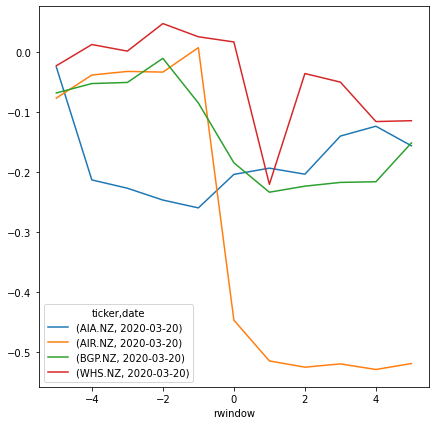

In [6]:
dfe, dfr, dfb, dfc, dfp = multi_stock(df_evt, 250, 5)

In [7]:
dfr

rm        ri    beta_1    beta_0     steyx  \
ticker date       rwindow                                                     
AIA.NZ 2020-03-20 -5.0    -0.050249 -0.081440  1.124106 -0.000647  0.012597   
                  -4.0    -0.036258 -0.234572  1.124106 -0.000647  0.012597   
                  -3.0    -0.004463 -0.023257  1.124106 -0.000647  0.012597   
                  -2.0     0.002133 -0.023811  1.124106 -0.000647  0.012597   
                  -1.0    -0.036662 -0.059214  1.124106 -0.000647  0.012597   
                   0.0     0.009512  0.085558  1.124106 -0.000647  0.012597   
                   1.0    -0.079468 -0.076881  1.124106 -0.000647  0.012597   
                   2.0     0.069366  0.064808  1.124106 -0.000647  0.012597   
                   3.0     0.016897  0.098250  1.124106 -0.000647  0.012597   
                   4.0     0.038963  0.062242  1.124106 -0.000647  0.012597   
                   5.0    -0.007894 -0.046766  1.124106 -0.000647  0.012597   
AIR.NZ 2020-03-20 -5.0    -0.050249 -0.133531  1.116216 -0.001242  0.013604   
                  -4.0    -0.036258  0.000000  1.116216 -0.001242  0.013604   
                  -3.0    -0.004463  0.000000  1.116216 -0.001242  0.013604   
                  -2.0     0.002133  0.000000  1.116216 -0.001242  0.013604   
                  -1.0    -0.036662  0.000000  1.116216 -0.001242  0.013604   
                   0.0     0.009512 -0.441833  1.116216 -0.001242  0.013604   
                   1.0    -0.079468 -0.213093  1.116216 -0.001242  0.013604   
                   2.0     0.069366  0.054725  1.116216 -0.001242  0.013604   
                   3.0     0.016897  0.029157  1.116216 -0.001242  0.013604   
                   4.0     0.038963  0.022728  1.116216 -0.001242  0.013604   
                   5.0    -0.007894  0.011173  1.116216 -0.001242  0.013604   
BGP.NZ 2020-03-20 -5.0    -0.050249 -0.090972  0.468053  0.000147  0.012279   
                  -4.0    -0.036258  0.000000  0.468053  0.000147  0.012279   
                  -3.0    -0.004463  0.000000  0.468053  0.000147  0.012279   
                  -2.0     0.002133  0.043485  0.468053  0.000147  0.012279   
                  -1.0    -0.036662 -0.092275  0.468053  0.000147  0.012279   
                   0.0     0.009512 -0.104395  0.468053  0.000147  0.012279   
                   1.0    -0.079468 -0.097243  0.468053  0.000147  0.012279   
                   2.0     0.069366  0.045746  0.468053  0.000147  0.012279   
                   3.0     0.016897  0.016130  0.468053  0.000147  0.012279   
                   4.0     0.038963  0.019803  0.468053  0.000147  0.012279   
                   5.0    -0.007894  0.079137  0.468053  0.000147  0.012279   
WHS.NZ 2020-03-20 -5.0    -0.050249 -0.065751  0.869379  0.000133  0.015753   
                  -4.0    -0.036258  0.004843  0.869379  0.000133  0.015753   
                  -3.0    -0.004463 -0.014599  0.869379  0.000133  0.015753   
                  -2.0     0.002133  0.047856  0.869379  0.000133  0.015753   
                  -1.0    -0.036662 -0.052770  0.869379  0.000133  0.015753   
                   0.0     0.009512  0.000000  0.869379  0.000133  0.015753   
                   1.0    -0.079468 -0.302571  0.869379  0.000133  0.015753   
                   2.0     0.069366  0.297632  0.869379  0.000133  0.015753   
                   3.0     0.016897  0.000000  0.869379  0.000133  0.015753   
                   4.0     0.038963 -0.035268  0.869379  0.000133  0.015753   
                   5.0    -0.007894 -0.005141  0.869379  0.000133  0.015753   

                               rsq   nobs    est_ret   abn_ret      tstat  \
ticker date       rwindow                                                   
AIA.NZ 2020-03-20 -5.0     0.333233  250.0 -0.057132 -0.024308  -1.929675   
                  -4.0     0.333233  250.0 -0.041405 -0.193168 -15.334541   
                  -3.0     0.333233  250.0 -0.005664 -0.017593  -1.396628   
             

In [8]:
dfr.loc['AIR.NZ']

rm        ri    beta_1    beta_0     steyx     rsq   \
date       rwindow                                                              
2020-03-20 -5.0    -0.050249 -0.133531  1.116216 -0.001242  0.013604  0.29672   
           -4.0    -0.036258  0.000000  1.116216 -0.001242  0.013604  0.29672   
           -3.0    -0.004463  0.000000  1.116216 -0.001242  0.013604  0.29672   
           -2.0     0.002133  0.000000  1.116216 -0.001242  0.013604  0.29672   
           -1.0    -0.036662  0.000000  1.116216 -0.001242  0.013604  0.29672   
            0.0     0.009512 -0.441833  1.116216 -0.001242  0.013604  0.29672   
            1.0    -0.079468 -0.213093  1.116216 -0.001242  0.013604  0.29672   
            2.0     0.069366  0.054725  1.116216 -0.001242  0.013604  0.29672   
            3.0     0.016897  0.029157  1.116216 -0.001242  0.013604  0.29672   
            4.0     0.038963  0.022728  1.116216 -0.001242  0.013604  0.29672   
            5.0    -0.007894  0.011173  1.116216 -0.001242  0.013604  0.29672   

                    nobs    est_ret   abn_ret      tstat       car  
date       rwindow                                                  
2020-03-20 -5.0     250.0 -0.057331 -0.076201  -5.601403 -0.076201  
           -4.0     250.0 -0.041713  0.041713   3.066289 -0.037666  
           -3.0     250.0 -0.006223  0.006223   0.457457 -0.031677  
           -2.0     250.0  0.001140 -0.001140  -0.083776 -0.032781  
           -1.0     250.0 -0.042165  0.042165   3.099454  0.008002  
            0.0     250.0  0.009376 -0.451208 -33.167658 -0.446817  
            1.0     250.0 -0.089946 -0.123148  -9.052396 -0.514940  
            2.0     250.0  0.076186 -0.021461  -1.577577 -0.525350  
            3.0     250.0  0.017620  0.011537   0.848065 -0.519874  
            4.0     250.0  0.042249 -0.019521  -1.434957 -0.529247  
            5.0     250.0 -0.010053  0.021226   1.560317 -0.519254

<AxesSubplot:xlabel='rwindow'>

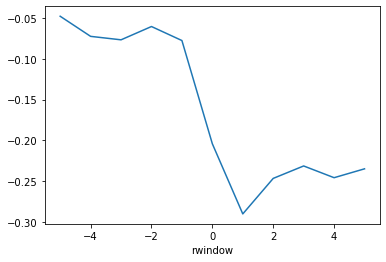

In [17]:
dfgp = dfr.groupby(['ticker', 'rwindow'])['car'].mean().unstack().mean()
dfgp
dfgp.plot()

In [18]:
dfretns =  pd.pivot_table(dfr['abn_ret'].reset_index(), values='abn_ret', index=['ticker', 'date'], columns=['rwindow'])#.sum().plot(kind='bar')
dfretns

,rwindow,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0
ticker,date,,,,,,,,,,,
AIA.NZ,2020-03-20,-0.024308,-0.193168,-0.017593,-0.025562,-0.017355,0.075512,0.013097,-0.012520,0.079903,0.019091,-0.037246
AIR.NZ,2020-03-20,-0.076201,0.041713,0.006223,-0.001140,0.042165,-0.451208,-0.123148,-0.021461,0.011537,-0.019521,0.021226
BGP.NZ,2020-03-20,-0.067599,0.016824,0.001942,0.042339,-0.075262,-0.108994,-0.060194,0.013132,0.008074,0.001419,0.082685
WHS.NZ,2020-03-20,-0.022199,0.036231,-0.010852,0.045868,-0.021030,-0.008403,-0.233616,0.237194,-0.014823,-0.069275,0.001588


In [19]:
dftstat =  pd.pivot_table(dfr['tstat'].reset_index(), values='tstat', index=['ticker', 'date'], columns=['rwindow'])#.sum().plot(kind='bar')
dftstat

,rwindow,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0
ticker,date,,,,,,,,,,,
AIA.NZ,2020-03-20,-1.929675,-15.334541,-1.396628,-2.029227,-1.377705,5.994529,1.039690,-0.993870,6.343036,1.515533,-2.956748
AIR.NZ,2020-03-20,-5.601403,3.066289,0.457457,-0.083776,3.099454,-33.167658,-9.052396,-1.577577,0.848065,-1.434957,1.560317
BGP.NZ,2020-03-20,-5.505447,1.370159,0.158151,3.448221,-6.129539,-8.876712,-4.902338,1.069488,0.657536,0.115560,6.734073
WHS.NZ,2020-03-20,-1.409164,2.299945,-0.688871,2.911674,-1.334962,-0.533386,-14.829761,15.056899,-0.940983,-4.397504,0.100827


In [20]:
wb = xw.Book()
sht = wb.sheets['Sheet1']
sht.range('A1').value = dfretns

wb.sheets.add()

sht = wb.sheets['Sheet2']
sht.range('A1').value = dftstat